## O desafio

Você foi contratado como um freelancer pela Eletronic House para ajudar o time de Marketing para ajustar uma nova página, a validar a sua efetividade de uma maneira mais segura, com mais conversão e rigidez na análise

- A conversão da nova página é realmente melhor do que a conversão atual?
- Qual o potencial de número de vendas que a nova página pode trazer
- Qual o faturamento total na venda do teclado bluetooth através da nova página?

Pelo que me lembro do desafio (vi no Insta @meigarom rs), o site antigo estava com 13% de conversão e o objetivo é aumentar para 15%. O número de conversão significa o número de compras por meio da página sobre o número de visitantes.

## Os dados

O conjunto de dados está disponível na plataforma do Kaggle, através desse link:
https://www.kaggle.com/datasets/zhangluyuan/ab-testing?select=ab_data.csv


# Legenda

Colunas:

- user_id : O id do usuário de cada sessão;
- timestamp : O timestamp (carimbo) para cada sessão;
- group : Define se o usuário do group é classificado como Controle ou Tratamento
- landing_page: Define como o usuário enxerga a página atual (old_page) a página que será testada (new_page);
- converted : dummy que indica se a sessão terminou em conversão (0 = não convetido, 1= convetido)

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math
import seaborn as sns
sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
%matplotlib inline
import statsmodels.stats.api as sms

# Carregando os dados

In [2]:
df = pd.read_csv("/Users/jonatas/Downloads/ab_data.csv")

In [3]:
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [4]:
# informaçoes sobre o tipo da variável
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
# Procurando por missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [6]:
#Verificando a quantidade de observações nos grupos controle e tratado
df['group'].value_counts().sort_index()

control      147202
treatment    147276
Name: group, dtype: int64

In [7]:
df['landing_page'].value_counts().sort_index()

new_page    147239
old_page    147239
Name: landing_page, dtype: int64

In [8]:
df['converted'].value_counts().sort_index()

0    259241
1     35237
Name: converted, dtype: int64

In [9]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,294478.0,NaN,NaN,NaN,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
timestamp,294478,294478,2017-01-21 22:11:48.556739,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
group,294478,2,treatment,147276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
landing_page,294478,2,old_page,147239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
converted,294478.0,NaN,NaN,NaN,0.119659,0.324563,0.0,0.0,0.0,0.0,1.0


 ## Análise de um teste A/B
 Em um teste bicaudal existem duas hipóteses:
 - Nula (H0): O efeito é nulo
 - Alternativa (H1): O efeito é não nulo
 
O nível de significância é a probabilidade de rejeitar a hipótese nula quando, de fato, a hipótese nula é verdadeira. Quanto maior a significância, maior a chance do efeito ser nulo.

Considerando alpha = 0.05, i.e, nosso nível de confiança  = 95%, queremos saber se, com 95% de certeza se mudança para a nova pagina web foi efetiva. Se o p_valor < 0.05 podemos rejeitar a hipótese nula.

Outro fator que deve ser levado em consideração é o tamanho da amostra para realização do teste A/B

In [10]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


# Calculando o tamanho do efeito
Para saber o número ideal da amostra, devemos realizar um "Power test" a fim de determinar o número necessário na amostra.

In [11]:
# Calculo do tamanho do efeito dado as taxas esperadas 
efeito = sms.proportion_effectsize(0.13, 0.15)

required_n = sms.NormalIndPower().solve_power(
            efeito,
            power = 0.8, #power test (o padrão é 0.8)
            alpha=0.05, # p-valor = 0.05
            ratio=1)

required_n = ceil(required_n)  # arredondando os números

print(required_n)

4720


Portanto, precisamos de 4720 usuários no grupo controle e no grupo de tratamento. 

## Processando os dados

In [12]:
# Vamos verificar se há multiplas entradas

session_counts = df['user_id'].value_counts(ascending = False)
duplicados = session_counts[session_counts > 1].count()

print(f'Existem {duplicados} usuários que aparecem mais de uma vez no dataset')

Existem 3894 usuários que aparecem mais de uma vez no dataset


In [13]:
# Temos que retirar as entradas que aparecem mais de uma vez
drop_usuarios = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(drop_usuarios)]
print(f'Agora o dataset possui {df.shape[0]} entradas')

Agora o dataset possui 286690 entradas


In [14]:
# Após limpo, podemos ver agora usuários somente na pagina nova ou na pagina antiga
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


In [17]:
tx_conversao = df.groupby('group')['converted']

#Desvio-padrão da proporção
#ddof=0 significa Delta Degrees of Freedom. Por padrão já é 0.
std_p = lambda x: np.std(x, ddof=0)

#Erro padrão da proporção (desv.padrao/raiz quadrada de n)
se_p = lambda x: stats.sem(x,ddof=0)

tx_conversao = tx_conversao.agg([np.mean, std_p, se_p])
tx_conversao.columns = ['tx_conversão', 'desv padrão', 'erro padrão']

tx_conversao.style.format('{:.3f}')

,tx_conversão,desv padrão,erro padrão
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.323,0.001


O grupo de controle mostra 12% de taxa de converão na pagina antiga (grupo de controle) e na nova página 11.9% (grupo controle) de taxa de conversão  

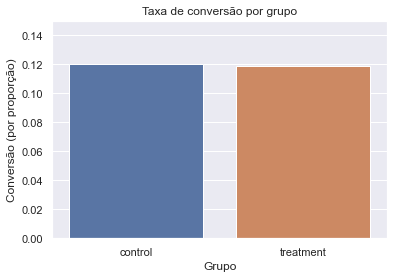

In [20]:
# Plotando a conversão por grupo
#ci = intervalo de confiança
sns.barplot(x=df['group'], y=df['converted'], ci=False)

plt.ylim(0, 0.15)
plt.title('Taxa de conversão por grupo')
plt.xlabel('Grupo')
plt.ylabel('Conversão (por proporção)')
plt.show()

## Teste de Hipótese


In [21]:
control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group']== 'treatment']['converted']

nr_control = control_results.count()
nr_treatment = control_results.count()
sucesso = [control_results.sum(), treatment_results.sum()]
nr_obs = [nr_control, nr_treatment]

In [26]:
z_stat, pvalue = proportions_ztest(sucesso, nobs=nr_obs)

#Intervalo de confiança
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(sucesso, nobs= nr_obs, alpha=0.05)

In [27]:
print('Z statistic : {:.2f}'.format(z_stat))
print('P-value : {:6.3f}'.format(pvalue))
print('Intervalo de confiança (95%) - grupo controle: [{:.3f},{:.3f}]'.format(lower_control, upper_control))
print('Intervalo de confiança (95%) - grupo tratado: [{:.3f},{:.3f}]'.format(lower_treatment, upper_treatment))


Z statistic : 1.12
P-value :  0.261
Intervalo de confiança (95%) - grupo controle: [0.118,0.122]
Intervalo de confiança (95%) - grupo tratado: [0.117,0.120]


O "Z statistic" nada mais é do que o número de desvios padrão entre a média da amostra e a média da população. O Z statistic pode ser usada para determinar a rejeição da hipótese nula ou não. A formula do Z statistic é: (média da amostra - média das obs da população)/ média do erro padrão da amostra.

Já o calculo da média do erro padrão na amostra é: desvio-padrão/raiz quadrada de n

Voltando a análise do nosso teste de hipótese, dado o P-valor = 0.261 que é maior do que nosso alpha (0.05), portanto, não se pode rejeitar a hipótese nula. Isto quer dizer que não é possível dizer com exatidão se a nova página tem melhor performance do que a antiga. Ambas possuem efeitos similares. Assim, respondendo a primeira pergunta do desafio, não, a conversão da nova página não é melhor do que a antiga.